In [ ]:
### Ler os arquivos 
Associar classificacao do especialista (vocal x não-vocal)

In [44]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.lib.display as display 
import mir3.modules.tool.wav2spectrogram as spec
from matplotlib.colors import Normalize
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from matplotlib.colors import ListedColormap
import scipy.io.wavfile

In [2]:
def fundamental_frequencies_extractor(x, window_length, window_step, sample_rate):
    t0 = 0
    window = window_length
    step = window_step
    f0 = []
    while t0+window < len(x):
        per_fun = t0_acc(x[t0:t0+window])
        if per_fun > 2:
            per_fun /= float(sample_rate)
            f0.append(1./per_fun)
        else:
            f0.append(0)
        t0 += step
    return f0

#Detecção de frequencia fundamental
def t0_acc(x):
    """Retorna o periodo fundamental de x, em amostras"""
    X = np.abs(np.fft.fft(x))
    r = np.real(np.fft.ifft(X*X))
    r2 = np.zeros(len(r)/2)
    for n in xrange(len(r2)):
        r2[n] = r[n][0]-r[n/2][0]
    r2 *= np.linspace(1, 0, len(r2))
    t0 = np.argmax(r2)
    return t0

### Time Domain Features
##Zero Crossing Rate

Zero-crossing rate is a simple, straightforward and inexpensive feature to examine the similarity between two or more accelerometer sensors. It measures whether two sets of time series measurements exhibit similar patters. It is particularly useful to analyze measurements that are corrupted by noise. For example, a measurement with a high zero-crossing rate, i.e., the number of samples per second that cross the zero reference line, indicates that it is noisy. However, we observe that even for sensors having the same orientation, the calibration error results in a deviation of 40s. Substituting the zero-crossing value by a mean valuecrossing, i.e., by defining a mean threshold that serves as a reference, results in a calibration error with a deviation between 2 and 15/s for individual axes and between 0 and 2/s for the absolute acceleration values of the individual measurements. Cross test of uncorrelated measurements, on the other hand, reveals that the overall calibration error is markedly bigger: between 7 and 50/s for the raw measurements and between 5 and 30/s for the absolute values.

The Zero Crossing Rate (ZCR) is defined by:

\[ zcr = \frac{1}{N-1} \sum_{i=1}^{N-1} | sign|x(i)| - sign|x(i-1)| | \]

where \(N\) is the number of samples of an audio file and the signum function is defined by:

\[ sign|x(i)| = \begin{cases} 1, & \text{ if } x(i) > 0\\ 0, & \text{ if } x(i) = 0\\ -1,&\text{ if } x(i) < 0 \end{cases} \]

average number of times the audio signal crosses the zero amplitude line per time unit. very simple to compute has been applied to speech processing to distinguish voiced sections from noise

also has been applied to MIR tasks such as classifying percussion sounds Genres

### Mel-Frequency Cepstral Coefficients (MFCC)
used previously in speech recognition
model human auditory response (Mel scale)
âcepstrumâ (s-p-e-c reversed): result of taking the Fourier transform (FFT) of the decibel spectrum as if it were a signal
show rate of change in the different spectrum bands
Dominant feature in speech recognition, because of ist ability to represent the speech amplitude spectrum in a compact form
has also prooved to be highly efficient in Music Retrieval
good timbre feature
represent the rate of change in the different spectrum bands


In [26]:
from os import listdir
from os.path import isfile, join
music_path = 'sons'

alto_files = [(f,'Alto') for f in listdir(music_path) if '_alto' in f and isfile(join(music_path, f))]
baritone_files = [(f, 'Baritone') for f in listdir(music_path) if '_baritone' in f and isfile(join(music_path, f))]
bass_files = [(f,'Bass') for f in listdir(music_path) if '_bass' in f and isfile(join(music_path, f))]
soprano_files = [(f, 'Soprano') for f in listdir(music_path) if '_soprano' in f and isfile(join(music_path, f))]
tenor_files = [(f,'Tenor') for f in listdir(music_path) if '_tenor' in f and isfile(join(music_path, f))]
acute_files = [(f,'Acute') for f in listdir(music_path) if '_acute' in f and isfile(join(music_path, f))]
grave_files = [(f,'Grave') for f in listdir(music_path) if '_grave' in f and isfile(join(music_path, f))]
percussive_files = [(f,'Percussive') for f in listdir(music_path) if '_percussive' in f and isfile(join(music_path, f))]

all_music_list = alto_files + baritone_files + bass_files + soprano_files + tenor_files + grave_files + percussive_files

#print ('All Vocal:', vocal_files)
#print ('All Non vocal:', non_vocal_files)
print ('All music:', len(all_music_list))

('All music:', 46)


### Usar os filtros
### A) Centróide Espectral
O centróide de uma forma geométrica indica o seu ponto de equilíbrio (assumindo densidade constante). Também, é um ponto que minimiza a soma das distâncias euclidianas (ponderadas pela magnitude) em relação a todos os outros pontos da forma abordada.  Se a forma é limitada por uma função $y[k] = f(k)$, então seu centróide pode ser calculado por:
$$\frac{\sum_{k=0}^{K-1} ky[k]}{\sum_{k=0}^{K-1}y[k]}.$$

Sob um ponto de vista perceptual, o centróide se correlaciona a uma propriedade chamada *brilho* (*brightness*). Um som muito brilhante é também entendido como "estridente", ao passo que um som mais opaco (menos brilhante) pode ser também descrito como "fechado". 

### B) Spectral Flatness
Espectros planos são geralmente relacionados a eventos percussivos e a ruído branco. O spectral flatness é calculado normalizando o espectro para que possa ser considerado um histograma de probabilidades (isto é, com soma unitária) e então estimando a entropia de Shannon desse histograma. Um espectro plano tem flatness igual a 1 e um espectro com apenas um componente diferente de zero tem flatness igual a zero.

### C) Roll-off Espectral
Roll-Off é o nome que se dá à frequência abaixo da qual se concentra mais de 95% da energia de um espectro. Esse número, 95%, depende da quantidade de ruído esperada em um sinal. Em verdade, espera-se que todo o conteúdo energético acima do roll-off se relacione somente a ruído.

### D) Energia
A energia é simplesmente a soma dos elementos de um quadro do espectrograma, elevados ao quadrado. Trata-se de um valor que é alto quando um som é perceptualmente intenso, e baixo em sons pouco intensos.

### E) Fluxo espectral
O fluxo espectral não é propriamente um descritor de forma local do espectro. Trata-se de uma quantificação do quanto o espectro de um quadro varia em relação ao anterior, considerando apenas os acréscimos de magnitude, ou:
$$f_q = \sum_{k=0}^{N-1} \max(X_q[k] - X_{q-1}[k], 0).$$

In [62]:
import mir3.modules.tool.wav2spectrogram as spectrogram
import mir3.modules.features.flatness as flatness
import mir3.modules.features.centroid as cent
import mir3.modules.features.rolloff as roll
import mir3.modules.features.energy as energ
import mir3.modules.features.flux as specfl
#import mir3.modules.features.td_zero_crossings as zerocross
#import mir3.modules.features.mfcc as mfcc

flat_samples = {}
centroid_samples = {}
roll_off_samples = {}
energy_samples = {}
spectral_flux_samples = {}
fundamental_frequencies_samples = {}
zero_crossing_rate = {}
rms_rate = {}
for (fname, label) in all_music_list:
    #print fname
    #print label
    
    #frequencia fundamental
    rate, data = scipy.io.wavfile.read(join(music_path,fname))
    #print("sampling rate = {} Hz, length = {} samples, channels = {}".format(rate,*data.shape))
    data = data.astype(np.float) 
    data_normalized = (data - np.mean(data))/np.sqrt(np.var(data))
    
    fundamental_freqs = fundamental_frequencies_extractor(x=data_normalized, window_length=1024, window_step=512, sample_rate=rate)
    fundamental_frequencies_samples[fname] = fundamental_freqs
    #print 'fundamental_freqs:', fundamental_freqs
      
    wav2spec = spectrogram.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrograma
    s = wav2spec.convert(open(join(music_path, fname), 'rb'), window_length=1024, window_step=512, spectrum_type='magnitude')

    #Centroid
    centr = cent.Centroid()
    centroid = centr.calc_track(s)
    #T = centroid.metadata.sampling_configuration.ofs
    #t = np.linspace(0, len(centroid.data)/T, len(centroid.data))
    centroid_samples[fname] = centroid.data

    #Spectral Flatness
    fness = flatness.Flatness()
    f = fness.calc_track(s)
    flat_samples[fname] = f.data
    
    #Roll-off 
    roff = roll.Rolloff()
    roll_off = roff.calc_track(s)
    roll_off_samples[fname] = roll_off.data
    #T = roll_off.metadata.sampling_configuration.ofs
    #t = np.linspace(0, len(roll_off.data)/T, len(roll_off.data))
    
    #Energy
    en = energ.Energy()
    energy = en.calc_track(s)
    #T = energy.metadata.sampling_configuration.ofs
    #t = np.linspace(0, len(energy.data)/T, len(energy.data))
    energy_samples[fname] = energy.data
    
    #Spectral Flux
    fl = specfl.Flux()
    flux = fl.calc_track(s)
    #T = flux.metadata.sampling_configuration.ofs
    #t = np.linspace(0, len(flux.data)/T, len(flux.data))
    spectral_flux_samples[fname] = flux.data
    
    #Mel-Frequency Cepstral Coefficients
    #melfreqcepstral = mfcc.Mfcc()
    #mel_freq_cepstral_coef = melfreqcepstral.calc_track(s)

#print 'Dictionary Centroid training samples:', centroid_samples    
#print 'Dictionary Flatness training samples:', flat_samples
#print 'Dictionary Roll-off training samples:', roll_off_samples 
#print 'Dictionary Energy training samples:', energy_samples 
#print 'Dictionary Spectral Flux training samples:', spectral_flux_samples
#print 'Dictionary Fundamental Frequencies training samples:', fundamental_frequencies_samples

### Visualizar - Calcular descritores (media e variancia) para flatness e ver dispersão

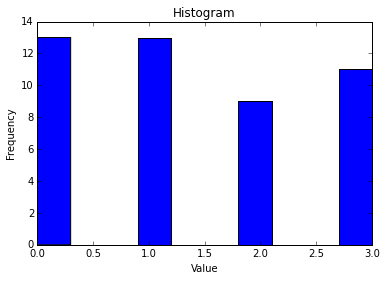

In [35]:
plt.figure();
classes_list = []
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    classes_list.append(index)
plt.hist(classes_list)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

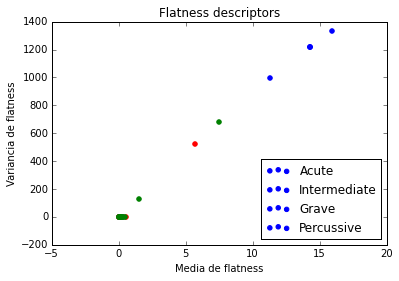

In [36]:
color=['red', 'blue','gray','green']
#labels=["Alto","Baritone","Bass","Soprano","Tenor","Acute","Grave","Percussive"]
labels=["Acute","Intermediate", "Grave","Percussive"]

plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    #print fname, np.mean(flat_samples[fname]), np.var(flat_samples[fname]), color[index], labels[index] 
    plt.scatter(np.mean(flat_samples[fname]), np.var(flat_samples[fname]), color=color[index], label=labels[index])
plt.title('Flatness descriptors')
plt.xlabel('Media de flatness')
plt.ylabel('Variancia de flatness')
plt.legend(labels, loc=4);
plt.show()

### Visualizar - Calcular descritores (media e variancia) para Centroid e ver dispersão

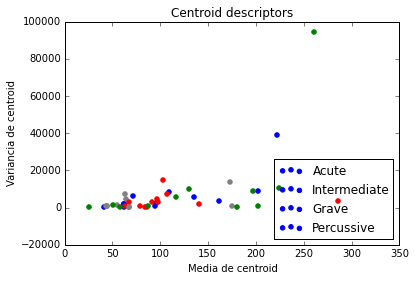

In [37]:
plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
        
    plt.scatter(np.mean(centroid_samples[fname]), np.var(centroid_samples[fname]), color=color[index], label=labels[index])
plt.title('Centroid descriptors')
plt.xlabel('Media de centroid')
plt.ylabel('Variancia de centroid')
plt.legend(labels, loc=4);
plt.show()

#### Freq Fundamental

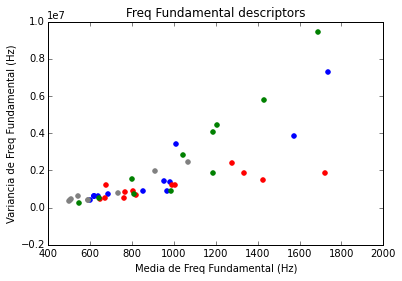

In [61]:
plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    plt.scatter(np.mean(fundamental_frequencies_samples[fname]), np.var(fundamental_frequencies_samples[fname]), color=color[index], label=labels[index])
plt.title('Freq Fundamental descriptors')
plt.xlabel('Media de Freq Fundamental (Hz)')
plt.ylabel('Variancia de Freq Fundamental (Hz)')
plt.show()

### Visualizar - Calcular descritores (media e variancia) para Roll-off e ver dispersão

In [ ]:
plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    plt.scatter(np.mean(roll_off_samples[fname]), np.var(roll_off_samples[fname]), color=color[index], label=labels[index])
plt.title('Roll-off descriptors')
plt.xlabel('Media de Roll-off')
plt.ylabel('Variancia de Roll-off')
plt.legend(labels, loc=4);
plt.show()

### Visualizar - Calcular descritores (media e variancia) para Energy e ver dispersão

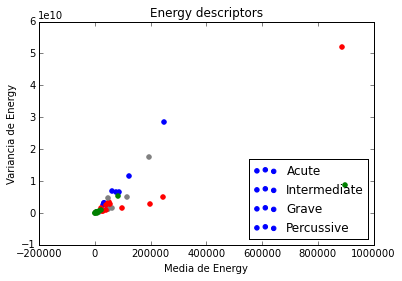

In [11]:
plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    plt.scatter(np.mean(energy_samples[fname]), np.var(energy_samples[fname]), color=color[index], label=labels[index])
plt.title('Energy descriptors')
plt.xlabel('Media de Energy')
plt.ylabel('Variancia de Energy')
plt.legend(labels, loc=4);
plt.show()

### Visualizar - Calcular descritores (media e variancia) para Spectral Flux e ver dispersão

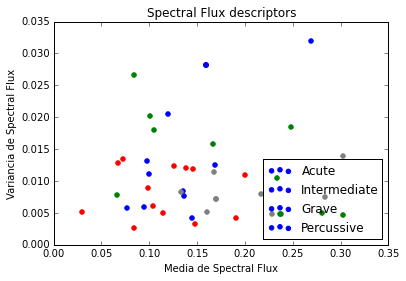

In [39]:
plt.figure();
for (fname, label) in all_music_list: 
    if '_alto' in fname:
        index = 1 #intermediate
    elif '_baritone' in fname:
        index = 1 #intermediate
    elif '_bass' in fname:
        index = 2 #grave
    elif '_soprano' in fname:
        index = 0 #acute
    elif '_tenor' in fname:
        index = 0 #acute
    elif '_acute' in fname:
        index = 0 
    elif '_grave' in fname:
        index = 2 
    else: #'_percussive' in fname:
        index = 3
    plt.scatter(np.mean(spectral_flux_samples[fname]), np.var(spectral_flux_samples[fname]), color=color[index], label=labels[index])
plt.title('Spectral Flux descriptors')
plt.xlabel('Media de Spectral Flux')
plt.ylabel('Variancia de Spectral Flux')
plt.legend(labels, loc=4);
plt.show()

### Calcular descritores (media e variancia) a partir de cada filtro (e normalizar)

In [65]:
descriptors_samples = {}
for (fname, label) in all_music_list:    
    descriptors = []
    
    #descriptors for flatness
    flat_normalized = (flat_samples[fname] - np.mean(flat_samples[fname]))/np.sqrt(np.var(flat_samples[fname]))
    flat_mean_normalized = np.mean(flat_normalized)
    flat_var_normalized = np.var(flat_normalized)
    flat_skew = scipy.stats.skew(flat_normalized)
    flat_kurtosis = scipy.stats.kurtosis(flat_normalized)
    flat_median = np.median(flat_normalized)
    flat_min = np.min(flat_normalized)
    flat_max = np.max(flat_normalized)
    flat_descriptors = [flat_mean_normalized, flat_var_normalized, flat_skew, flat_kurtosis, flat_median, flat_min, flat_max]
    
    #descriptors for centroid
    centroid_normalized = (centroid_samples[fname] - np.mean(centroid_samples[fname]))/np.sqrt(np.var(centroid_samples[fname]))
    centroid_mean_normalized = np.mean(centroid_normalized)
    centroid_var_normalized = np.var(centroid_normalized)
    centroid_descriptors = [centroid_mean_normalized, centroid_var_normalized]
    
    #descriptors for roll-off
    roll_off_normalized = (roll_off_samples[fname] - np.mean(roll_off_samples[fname]))/np.sqrt(np.var(roll_off_samples[fname]))
    roll_off_mean_normalized = np.mean(roll_off_normalized)
    roll_off_var_normalized = np.var(roll_off_normalized)
    roll_off_descriptors = [roll_off_mean_normalized, roll_off_var_normalized]
    
    #descriptors for energy
    energy_normalized = (energy_samples[fname] - np.mean(energy_samples[fname]))/np.sqrt(np.var(energy_samples[fname]))
    energy_mean_normalized = np.mean(energy_normalized)
    energy_var_normalized = np.var(energy_normalized)
    energy_descriptors = [energy_mean_normalized, energy_var_normalized]
    
    #descriptors for spectral flux        
    spectral_flux_normalized = (spectral_flux_samples[fname] - np.mean(spectral_flux_samples[fname]))/np.sqrt(np.var(spectral_flux_samples[fname]))
    spectral_flux_mean_normalized = np.mean(spectral_flux_normalized)
    spectral_flux_var_normalized = np.var(spectral_flux_normalized)
    spectral_flux_descriptors = [spectral_flux_mean_normalized, spectral_flux_var_normalized]
    
    #descriptors for fundamental frequency       
    fundamental_frequencies_normalized = (fundamental_frequencies_samples[fname] - np.mean(fundamental_frequencies_samples[fname]))/np.sqrt(np.var(fundamental_frequencies_samples[fname]))
    fundamental_frequencies_mean_normalized = np.mean(spectral_flux_normalized)
    fundamental_frequencies_var_normalized = np.var(spectral_flux_normalized)
    fundamental_frequencies_descriptors = [fundamental_frequencies_mean_normalized, fundamental_frequencies_var_normalized]
    
    #all_descriptors = [flat_mean_normalized, flat_var_normalized,
    #              centroid_mean_normalized, centroid_var_normalized,
    #              roll_off_mean_normalized, roll_off_var_normalized,
    #              energy_mean_normalized, energy_var_normalized,
    #              spectral_flux_mean_normalized, spectral_flux_normalized]
    descriptors_samples[fname] = (flat_descriptors, centroid_descriptors, roll_off_descriptors, energy_descriptors, 
                              spectral_flux_descriptors,fundamental_frequencies_descriptors, label)

#print 'Descriptors dictionary', descriptors_samples

### Separar os dados (treino, validacao e teste) 
Quebrar em 60% para treino e 40% para testes

In [66]:
from sklearn import cross_validation
train_list = []
test_list = []
#repeat_split = 1
#for j in range(repeat_split):
train, test = cross_validation.train_test_split(all_music_list, train_size=0.6, test_size=0.4)
train_list.append(train)
test_list.append(test)
#print 'Selected train:', len(train)
#print 'Selected test:', len(test)

### Definir matrizes de treino, validação e teste

In [67]:
descriptors_labels = ['Flatness','Centroid','Spectral Flux', 'Roll off','Energy','Fundamental Frequencies'] 
descriptors_map = {'Flatness':0,'Centroid':1,'Roll off':2,'Energy':3,'Spectral Flux':4, 'Fundamental Frequencies':5}
#descriptor_sets_list = []

#for j in range(repeat_split):
descriptor_sets = []

for k in range(len(descriptors_labels)):
    #print k
    print 'Descriptor used:', descriptors_labels[k]  
    k_index = descriptors_map[descriptors_labels[k]]
    print 'k_index:', k_index
    #print 'treino:\n'
    X_train = []
    y_train = []
    for (fname, label) in train: 
        X_train.append(descriptors_samples[fname][k_index])
        if '_alto' in fname:
            value = 1 #intermediate
        elif '_baritone' in fname:
            value = 1 #intermediate
        elif '_bass' in fname:
            value = 2 #grave
        elif '_soprano' in fname:
            value = 0 #acute
        elif '_tenor' in fname:
            value = 0 #acute
        elif '_acute' in fname:
            value = 0 
        elif '_grave' in fname:
            value = 2 
        else: #'_percussive' in fname:
            value = 3
        y_train.append(value)
        #print len(X_train)
        #print 'X_train:', X_train
        #print len(y_train)
        #print 'Y_train:', y_train
        #print '\n'

    #print 'teste:\n'
    X_test = []
    y_test = []
    #test = test_list[j]
    for (fname, label) in test: 
        X_test.append(descriptors_samples[fname][k_index])
        if '_alto' in fname:
            value = 1 #intermediate
        elif '_baritone' in fname:
            value = 1 #intermediate
        elif '_bass' in fname:
            value = 2 #grave
        elif '_soprano' in fname:
            value = 0 #acute
        elif '_tenor' in fname:
            value = 0 #acute
        elif '_acute' in fname:
            value = 0 
        elif '_grave' in fname:
            value = 2 
        else: #'_percussive' in fname:
            value = 3
        y_test.append(value)
        #print len(X_test)
        #print 'X_test:', X_test
        #print len(y_test)
        #print 'Y_test:', y_test
    descriptor_sets.append((X_train,y_train,X_test,y_test))
#print 'descriptor_sets:', descriptor_sets
#descriptor_sets_list.append(descriptor_sets)

Descriptor used: Flatness
k_index: 0
Descriptor used: Centroid
k_index: 1
Descriptor used: Spectral Flux
k_index: 4
Descriptor used: Roll off
k_index: 2
Descriptor used: Energy
k_index: 3
Descriptor used: Fundamental Frequencies
k_index: 5


### Definir modelo(s) de classificação
#### A) Knn nearest neighbors

#### Treinar modelo com dados de Treinamento

#### Realizar predição com dados de Validação
80% para treino e 20% para validaçao

#### Avaliar score com dados de Validação para escolher melhor parâmetro
##### A) Knn

In [68]:
i=0
classifiers = []
names = []
for ds in descriptor_sets:
    X_train,y_train,X_test,y_test = ds
    descriptor_used_label = descriptors_labels[i]
    n_neighbors_range = np.linspace(2, 10, num=9)
    param_grid = dict(n_neighbors=n_neighbors_range, weights=['uniform', 'distance'])
    validation = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2)
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=validation)
    print 'X_train:', len(X_train)
    print 'y_train:', len(y_train)
    grid.fit(X_train, y_train)

    print("Os melhores parametros para Knn com descritor %s , params %s com um score de %0.2f"
          % (descriptor_used_label, grid.best_params_, grid.best_score_))
    knn_neighbors_best_param = grid.best_params_['n_neighbors']
    names.append('KNN_'+descriptor_used_label)
    classifiers.append(KNeighborsClassifier(n_neighbors=knn_neighbors_best_param))
    i=i+1

X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Flatness , params {'n_neighbors': 10.0, 'weights': 'distance'} com um score de 0.29
X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Centroid , params {'n_neighbors': 4.0, 'weights': 'distance'} com um score de 0.51
X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Spectral Flux , params {'n_neighbors': 10.0, 'weights': 'uniform'} com um score de 0.31
X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Roll off , params {'n_neighbors': 7.0, 'weights': 'distance'} com um score de 0.34
X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Energy , params {'n_neighbors': 6.0, 'weights': 'uniform'} com um score de 0.51
X_train: 27
y_train: 27
Os melhores parametros para Knn com descritor Fundamental Frequencies , params {'n_neighbors': 10.0, 'weights': 'uniform'} com um score de 0.29


### Avaliar score com diferentes modelos (predição nos dados de teste)
Melhor modelo Knn

### Usar estatísticas de significância para verificar se há diferença entre os modelos estudados (p-score)
Se P <= 0.05, há confiança de que as distribuições diferentem significativamente, e podemos afirmar que o modelo aplicado tem um impacto significativo sobre o valor medido. 

In [69]:
from sklearn.metrics import classification_report
from scipy import stats  

y_knn_mean_list_centroid = []
y_knn_mean_list_flatness = []
y_knn_mean_list_roll_off = []
y_knn_mean_list_energy = []
y_knn_mean_list_spectral_flux = []
y_knn_mean_list_fundamental_freq = []
i=0
for ds in descriptor_sets:
    #print k
    k_index = descriptors_map[descriptors_labels[i]]
    print 'k_index:', k_index
    knn_score_list = []
    descriptor_used_label = descriptors_labels[i]
    print '-------------------------------------------\n'
    print 'Descriptor used %s\n' % (descriptor_used_label)

    X_train,y_train,X_test,y_test = ds
    best_knn = classifiers[i] #best knn for the given classifier
    print 'best_knn:', best_knn
    best_knn.fit(X_train, y_train)
    y_knn_predicted = best_knn.predict(X_test)
    print 'KNN      test:', np.array(y_test)
    print 'KNN predicted:', np.array(y_knn_predicted)
    target_names = labels
    knn_score = best_knn.score(X_test, y_test)
    print 'Knn score:', knn_score
    if k_index==0:
        y_knn_mean_list_centroid.append(knn_score)
    elif k_index==1:
        y_knn_mean_list_flatness.append(knn_score)
    elif k_index==2:
        y_knn_mean_list_roll_off.append(knn_score)
    elif k_index==3:
        y_knn_mean_list_energy.append(knn_score)
    elif k_index==4:
        y_knn_mean_list_spectral_flux.append(knn_score)
    elif k_index==5:
        y_knn_mean_list_fundamental_freq.append(knn_score)
    print(classification_report(y_test, y_knn_predicted, target_names=target_names))
    i+=1

k_index: 0
-------------------------------------------

Descriptor used Flatness

best_knn: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10.0, p=2, weights='uniform')
KNN      test: [3 0 1 0 1 0 1 2 3 2 2 0 3 1 1 2 0 1 2]
KNN predicted: [0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 3 0 3 0]
Knn score: 0.210526315789
              precision    recall  f1-score   support

       Acute       0.27      0.80      0.40         5
Intermediate       0.00      0.00      0.00         6
       Grave       0.00      0.00      0.00         5
  Percussive       0.00      0.00      0.00         3

 avg / total       0.07      0.21      0.11        19

k_index: 1
-------------------------------------------

Descriptor used Centroid

best_knn: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=4.0, p=2, weights='uniform')
KNN      test: [3 0 1 0 1 0 1 2 3 2 2 0 3 1 1 2 0 1 2]
KNN pre

#### Comparing Centroid with the others

In [60]:
print '-------------------------------------------\n'
z_stat, p_val = stats.ranksums(y_knn_mean_list_centroid, y_knn_mean_list_flatness)    
t, prob = stats.ttest_ind(y_knn_mean_list_centroid, y_knn_mean_list_flatness, equal_var = False)
print "MWW RankSum P for results Centroid and Flatness =", p_val
#print "T-test for results Centroid and Flatness =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_centroid, y_knn_mean_list_roll_off)    
t, prob = stats.ttest_ind(y_knn_mean_list_centroid, y_knn_mean_list_roll_off, equal_var = False)
print "MWW RankSum P for results Centroid and Roll off =", p_val
#print "T-test for results Centroid and Roll off =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_centroid, y_knn_mean_list_energy)    
t, prob = stats.ttest_ind(y_knn_mean_list_centroid, y_knn_mean_list_energy, equal_var = False)
print "MWW RankSum P for results Centroid and Energy =", p_val
#print "T-test for results Centroid and Energy =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_centroid, y_knn_mean_list_spectral_flux)    
t, prob = stats.ttest_ind(y_knn_mean_list_centroid, y_knn_mean_list_spectral_flux, equal_var = False)
print "MWW RankSum P for results Centroid and Spectral Flux =", p_val
#print "T-test for results Centroid and Spectral Flux =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_centroid, y_knn_mean_list_fundamental_freq)    
t, prob = stats.ttest_ind(y_knn_mean_list_centroid, y_knn_mean_list_fundamental_freq, equal_var = False)
print "MWW RankSum P for results Centroid and Fundamental Frequency =", p_val
#print "T-test for results Centroid and Spectral Flux =", t, prob
print '-------------------------------------------\n'

-------------------------------------------

MWW RankSum P for results Centroid and Flatness = 0.317310507863
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Centroid and Roll off = 0.317310507863
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Centroid and Energy = 0.317310507863
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Centroid and Spectral Flux = 0.317310507863
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Centroid and Fundamental Frequency = 0.317310507863
-------------------------------------------



#### Comparing Flatness with the others

In [50]:
print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_flatness, y_knn_mean_list_roll_off)    
t, prob = stats.ttest_ind(y_knn_mean_list_flatness, y_knn_mean_list_roll_off, equal_var = False)
print "MWW RankSum P for results Flatness and Roll off =", p_val
#print "T-test for results Flatness and Roll off =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_flatness, y_knn_mean_list_energy)    
t, prob = stats.ttest_ind(y_knn_mean_list_flatness, y_knn_mean_list_energy, equal_var = False)
print "MWW RankSum P for results Flatness and Energy =", p_val
#print "T-test for results Flatness and Energy =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_flatness, y_knn_mean_list_spectral_flux)    
t, prob = stats.ttest_ind(y_knn_mean_list_flatness, y_knn_mean_list_spectral_flux, equal_var = False)
print "MWW RankSum P for results Flatness and Spectral Flux =", p_val
#print "T-test for results Flatness and Spectral Flux =", t, prob
print '-------------------------------------------\n'

-------------------------------------------

MWW RankSum P for results Flatness and Roll off = 0.317310507863
T-test for results Flatness and Roll off = nan nan
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Flatness and Energy = 0.317310507863
T-test for results Flatness and Energy = nan nan
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Flatness and Spectral Flux = 0.317310507863
T-test for results Flatness and Spectral Flux = nan nan
-------------------------------------------



#### Comparing Roll-off with the others

In [51]:
print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_roll_off, y_knn_mean_list_energy)    
t, prob = stats.ttest_ind(y_knn_mean_list_roll_off, y_knn_mean_list_energy, equal_var = False)
print "MWW RankSum P for results Roll-off and Energy =", p_val
#print "T-test for results Roll-off and Energy =", t, prob
print '-------------------------------------------\n'

print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_roll_off, y_knn_mean_list_spectral_flux)    
t, prob = stats.ttest_ind(y_knn_mean_list_roll_off, y_knn_mean_list_spectral_flux, equal_var = False)
print "MWW RankSum P for results Roll-off and Spectral Flux =", p_val
#print "T-test for results Roll-off and Spectral Flux =", t, prob
print '-------------------------------------------\n'

-------------------------------------------

MWW RankSum P for results Roll-off and Energy = 0.317310507863
T-test for results Roll-off and Energy = nan nan
-------------------------------------------

-------------------------------------------

MWW RankSum P for results Roll-off and Spectral Flux = 0.317310507863
T-test for results Roll-off and Spectral Flux = nan nan
-------------------------------------------



#### Comparing Energy with the others

In [52]:
print '-------------------------------------------\n'    
z_stat, p_val = stats.ranksums(y_knn_mean_list_energy, y_knn_mean_list_spectral_flux)    
t, prob = stats.ttest_ind(y_knn_mean_list_energy, y_knn_mean_list_spectral_flux, equal_var = False)
print "MWW RankSum P for results Energy and Spectral Flux =", p_val
#print "T-test for results Energy and Spectral Flux =", t, prob
print '-------------------------------------------\n'

-------------------------------------------

MWW RankSum P for results Energy and Spectral Flux = 0.317310507863
T-test for results Energy and Spectral Flux = nan nan
-------------------------------------------

